An example notebook showing how to load lists of exposures and make plots

In [1]:
import sys
sys.path.append('..')
from cmost_exposure import load_by_file_prefix, load_by_filepath, scan_headers

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

cmost_dir = '../data'

## Loading exposures

Loading FITS files into Exposure objects takes the most time, so do it once in its own cell near the beginning of the notebook.

If you know that you just want all files beginning with a single prefix, load_by_file_prefix() is a shortcut for getting all files with that prefix.

In [2]:
# Load data from the cmostjpl003 data set using load_by_file_prefix()
file_prefix = cmost_dir+'/012121/cmostjpl003'

exposures = load_by_file_prefix(file_prefix)

Otherwise, you can be a bit more sophisticated by scanning the FITS headers in a directory using scan_headers(), filtering and sorting for the exact files you want to load, then loading by passing a list of filepaths to load_by_filepath().

In [2]:
# Alternate way of loading the cmostjpl003 data set using scan_headers()
all_files = scan_headers(cmost_dir+'/012121')

# I've decided I only want cmostjpl003_* files with exposure time < 10000ms, sorted by date
subset = (all_files['EXPTIME'] < 10000) & (all_files['DATE'] > datetime.fromisoformat('2021-01-21T20:57:00'))
files = all_files[subset]
files.sort('DATE')

files.pprint_all()

exposures = load_by_filepath(files['FILEPATH'])

                   FILEPATH                    READOUTM            DATE            EXPTIME LED    TEMP  CAMERAID DETID GAIN
---------------------------------------------- -------- -------------------------- ------- ---- ------- -------- ----- ----
../data/012121/cmostjpl003_20210121205739.fits  DEFAULT 2021-01-21 20:57:43.218747  1000.0  1.6 140.001                    
../data/012121/cmostjpl003_20210121205743.fits  DEFAULT 2021-01-21 20:57:47.488912  1221.0  1.6 140.001                    
../data/012121/cmostjpl003_20210121205747.fits  DEFAULT 2021-01-21 20:57:52.482085  1492.0  1.6 140.001                    
../data/012121/cmostjpl003_20210121205752.fits  DEFAULT 2021-01-21 20:57:58.323579  1823.0  1.6 140.001                    
../data/012121/cmostjpl003_20210121205758.fits  DEFAULT 2021-01-21 20:58:05.222302  2227.0  1.6 140.001                    
../data/012121/cmostjpl003_20210121205805.fits  DEFAULT 2021-01-21 20:58:13.388925  2721.0  1.6 140.001                    
../data/

Now that you have a list of exposures, you can get whatever data you need out of them and perform fitting/plotting.

In [6]:
# Define a subframe (region of interest) in the format (x1, x2, y1, y2)
subframe = (2600,2700,200,300)

# Populate arrays for fitting/plotting
n_exp = len(exposures)
exp_times, led, mean, median, var = np.zeros(n_exp), np.zeros(n_exp), np.zeros(n_exp), np.zeros(n_exp), np.zeros(n_exp)
for i in range(n_exp):
    exp_times[i] = exposures[i].exp_time
    led[i] = exposures[i].led_voltage
    mean[i] = exposures[i].get_mean(subframe)
    median[i] = exposures[i].get_median(subframe)
    var[i] = exposures[i].get_variance(subframe)

leds = np.unique(led)

Not enough frames to calculate variance
Not enough frames to calculate variance
Not enough frames to calculate variance


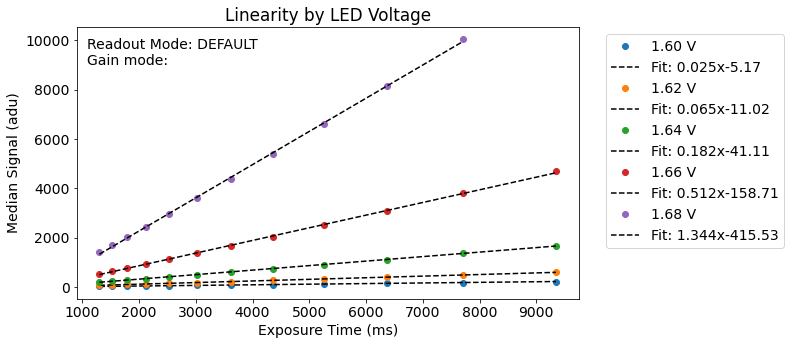

In [22]:
# Plot the linearity curve
plt.figure(figsize=[9,5])
plt.title('Linearity by LED Voltage')

# Add true readout time
timecomp = 300 

for l in leds:
    # Plot signal vs exposure time
    exp_time = exp_times[led == l] + timecomp
    signal = median[led == l]
    
    plt.plot(exp_time,signal,'o',label='{:.2f} V'.format(l))
    
    # Linear fit to unsaturated data 
    mask = signal < 12000
    m, b = np.polyfit(exp_time, signal, 1, w=mask)
    poly1d_fn = np.poly1d([m,b]) 
    
    plt.plot(exp_time,poly1d_fn(exp_time),'--k',label='Fit: {:.3f}x{:.2f}'.format(m, b))

plt.xlabel('Exposure Time (ms)')
plt.ylabel('Median Signal (adu)')

# Plot information
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
info = 'Readout Mode: {}\nGain mode: {}'.format(exposures[0].readout_mode,exposures[0].gain)
plt.annotate(info, xy=(0.02, 0.86), xycoords='axes fraction')

plt.savefig('plots/20210203_Linearity_vs_LED.pdf')
plt.show()
plt.close()

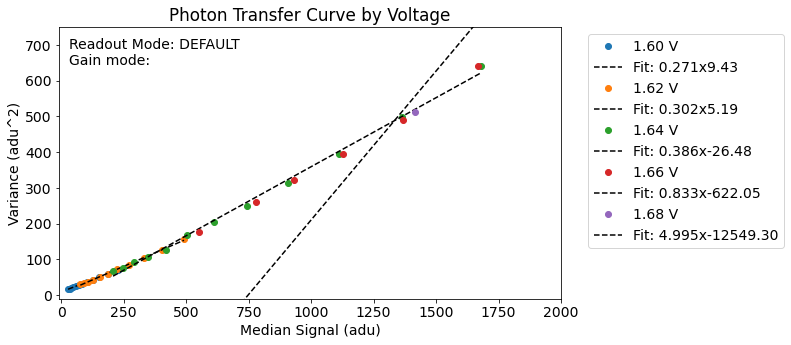

In [26]:
# Plot the photon transfer curve
plt.figure(figsize=[9,5])
plt.title('Photon Transfer Curve by Voltage')

for l in leds:
    # Plot variance vs signal
    signal = median[(led == l) & (var > 0)]
    variance = var[(led == l) & (var > 0)]
    
    plt.plot(signal,variance,'o',label='{:.2f} V'.format(l))
    
    # Linear fit to lower variance data
    mask = np.array(variance) < 80000
    m, b = np.polyfit(signal, variance, 1, w=mask)
    poly1d_fn = np.poly1d([m, b]) 
    
    plt.plot(signal,poly1d_fn(signal),'--k',label='Fit: {:.3f}x{:.2f}'.format(m, b))

plt.xlabel('Median Signal (adu)')
plt.ylabel('Variance (adu^2)')
plt.xlim([-10,2000])
plt.ylim([-10,750])

# Plot information
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
info = 'Readout Mode: {}\nGain mode: {}'.format(exposures[0].readout_mode,exposures[0].gain)
plt.annotate(info, xy=(0.02, 0.86), xycoords='axes fraction')

plt.savefig('plots/20210203_PTC_vs_LED.pdf')
plt.show()
plt.close()